In [72]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 1: Fetch Data
start_date = "2010-01-01"
end_date = "2024-12-31"
risk_free_ticker = "^IRX"  # Use the 13-week Treasury yield as a proxy for risk-free rate
market_index_ticker = "^GSPC"  # S&P 500 index
equity_tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA"]  # Replace with desired stock tickers

# Fetch data
risk_free_data = yf.download(risk_free_ticker, start=start_date, end=end_date)["Close"]
market_data = yf.download(market_index_ticker, start=start_date, end=end_date)["Close"]
stock_data = yf.download(equity_tickers, start=start_date, end=end_date)["Close"]

# Step 2: Prepare Data
# Calculate daily returns
market_returns = market_data.pct_change().dropna()
stock_returns = stock_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed


In [73]:
stock_returns.head()

Ticker,AAPL,GOOGL,MSFT,NVDA,TSLA
Date,,,,,
2010-06-30,-0.018114,-0.020495,-0.012870,-0.025763,-0.002511
2010-07-01,-0.012125,-0.012271,0.006519,0.016650,-0.078473
2010-07-02,-0.006198,-0.006689,0.004749,-0.012524,-0.125683
2010-07-06,0.006844,-0.001100,0.023636,-0.010732,-0.160937
2010-07-07,0.040381,0.032403,0.020151,0.048323,-0.019243


In [74]:
stock_returns['AAPL'].mean()

np.float64(0.00110832047942934)

In [75]:
# import matplotlib.pyplot as plt

# # Assuming stock_data['NVDA'] contains the data for NVIDIA's stock
# plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
# plt.plot(stock_data['NVDA'], label='NVIDIA Stock Prices')
# plt.title('NVIDIA Stock Price Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

import plotly.graph_objects as go

# Assuming stock_data['NVDA'] contains the data for NVIDIA's stock
fig = go.Figure()

# Add a line plot for NVIDIA stock prices
fig.add_trace(go.Scatter(
    x=stock_data.index,  # Assuming the index contains dates
    y=stock_data['NVDA'],
    mode='lines',
    name='NVIDIA Stock Prices'
))

# Add a line plot for NVIDIA stock prices
fig.add_trace(go.Scatter(
    x=stock_data.index,  # Assuming the index contains dates
    y=stock_data['TSLA'],
    mode='lines',
    name='TSLA Stock Prices'
))

# Customize the layout
fig.update_layout(
    title='NVIDIA Stock Price Over Time',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True
)

# Show the plot
fig.show()

In [76]:
# Import FF Factors
FF_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
FF_df['Date'] = pd.to_datetime(FF_df['Date'], format='%Y%m%d')
FF_df['Mkt-RF'] = FF_df['Mkt-RF']/100
FF_df['SMB'] = FF_df['SMB']/100
FF_df['HML'] = FF_df['HML']/100
FF_df['RF'] = FF_df['RF']/100


# Merge the FF Factors to Stocks
stock_returns = stock_returns.merge(FF_df, on = 'Date', how = 'inner')

# print minimal and maximum dates
print(stock_returns['Date'].min(), stock_returns['Date'].max())

2010-06-30 00:00:00 2024-11-29 00:00:00


In [77]:
stock_returns.head()

,Date,AAPL,GOOGL,MSFT,NVDA,TSLA,Mkt-RF,SMB,HML,RF
0,2010-06-30,-0.018114,-0.020495,-0.012870,-0.025763,-0.002511,-0.0098,0.0005,-0.0035,0.00001
1,2010-07-01,-0.012125,-0.012271,0.006519,0.016650,-0.078473,-0.0040,-0.0031,-0.0043,0.00001
2,2010-07-02,-0.006198,-0.006689,0.004749,-0.012524,-0.125683,-0.0050,-0.0030,-0.0044,0.00001
3,2010-07-06,0.006844,-0.001100,0.023636,-0.010732,-0.160937,0.0033,-0.0200,0.0011,0.00001
4,2010-07-07,0.040381,0.032403,0.020151,0.048323,-0.019243,0.0317,0.0005,0.0043,0.00001


In [78]:
stock_returns['AAPL'].median(), stock_returns['Mkt-RF'].median()

(np.float64(0.0009420915283924192), np.float64(0.0007000000000000001))

In [79]:
stock_returns[stock_returns['Mkt-RF'].isna()]

,Date,AAPL,GOOGL,MSFT,NVDA,TSLA,Mkt-RF,SMB,HML,RF


# Compare CAPM and Three-Factor Model

In [80]:
# use CAPM model
stock = 'AAPL'

# Stock excess return ~ market excess return
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns['Mkt-RF']
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())


CAPM model AAPL: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.459
Method:                 Least Squares   F-statistic:                              3085.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):                        0.00
Time:                        01:52:36   Log-Likelihood:                          10646.
No. Observations:                3630   AIC:                                 -2.129e+04
Df Residuals:                    3629   BIC:                                 -2.128e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [81]:
# Three factor model
y = stock_returns[stock] - stock_returns['RF']
x = stock_returns[['Mkt-RF', 'SMB', 'HML']]
model = sm.OLS(y, x).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())


CAPM model AAPL: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.510
Model:                            OLS   Adj. R-squared (uncentered):              0.510
Method:                 Least Squares   F-statistic:                              1258.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):                        0.00
Time:                        01:52:40   Log-Likelihood:                          10824.
No. Observations:                3630   AIC:                                 -2.164e+04
Df Residuals:                    3627   BIC:                                 -2.162e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Accuracy CAPM

In [82]:
# Split train and test
train_test_split = '2022-01-01'
Train_df = stock_returns[stock_returns['Date'] < train_test_split]
Test_df = stock_returns[stock_returns['Date'] >= train_test_split]

In [83]:
# CAPM
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df['Mkt-RF']
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model AAPL: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.427
Model:                            OLS   Adj. R-squared (uncentered):              0.426
Method:                 Least Squares   F-statistic:                              2156.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):                        0.00
Time:                        01:52:45   Log-Likelihood:                          8401.1
No. Observations:                2898   AIC:                                 -1.680e+04
Df Residuals:                    2897   BIC:                                 -1.679e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

/tmp/ipykernel_4684/115163375.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Mean Absolute Error (MAE): 0.007886959979085686


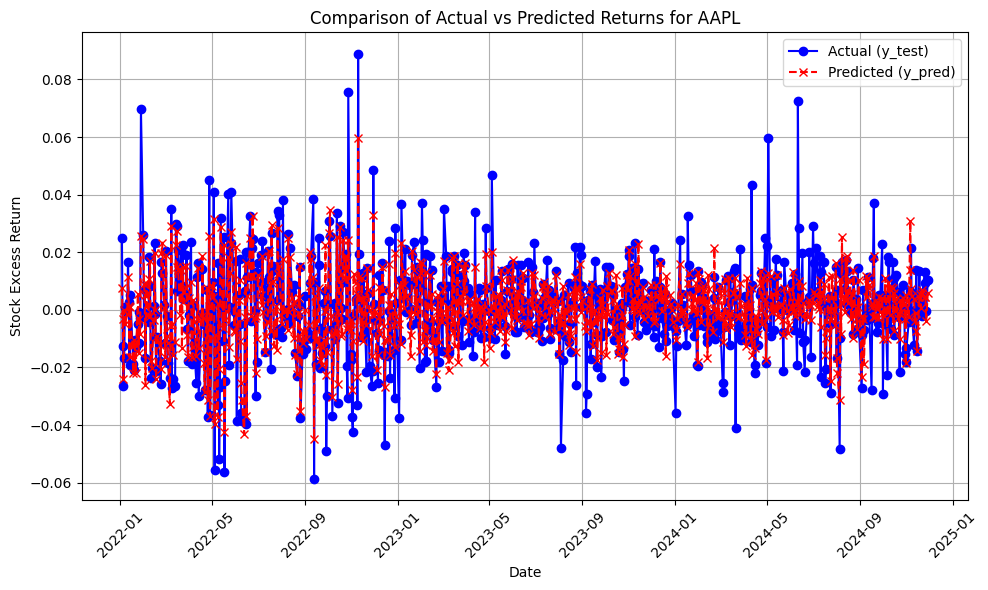

In [84]:
# CAPM test
y_test = Test_df[stock]
x_test = Test_df['Mkt-RF']
y_pred = Test_df['Mkt-RF'] * model.params[0] + Test_df['RF']

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

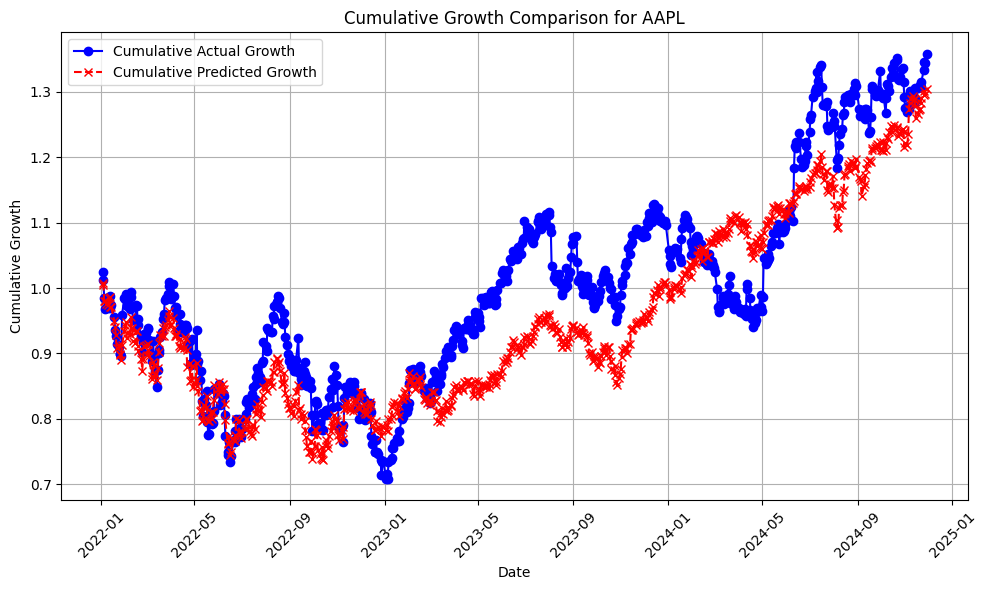

Final Cumulative Growth (Actual): 1.36
Final Cumulative Growth (Predicted): 1.30


In [85]:
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")

# Accuracy of Three Factor

In [86]:
# CAPM
# Stock excess return ~ market excess return
y_train = Train_df[stock] - Train_df['RF']
x_train = Train_df[['Mkt-RF', 'SMB', 'HML']]
model = sm.OLS(y_train, x_train).fit()
print(f"CAPM model {stock}: beta is")
print(model.summary())

CAPM model AAPL: beta is
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.482
Method:                 Least Squares   F-statistic:                              898.4
Date:                Sun, 26 Jan 2025   Prob (F-statistic):                        0.00
Time:                        01:53:07   Log-Likelihood:                          8548.5
No. Observations:                2898   AIC:                                 -1.709e+04
Df Residuals:                    2895   BIC:                                 -1.707e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

/tmp/ipykernel_4684/182984457.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Mean Absolute Error (MAE): 0.007669169315171268


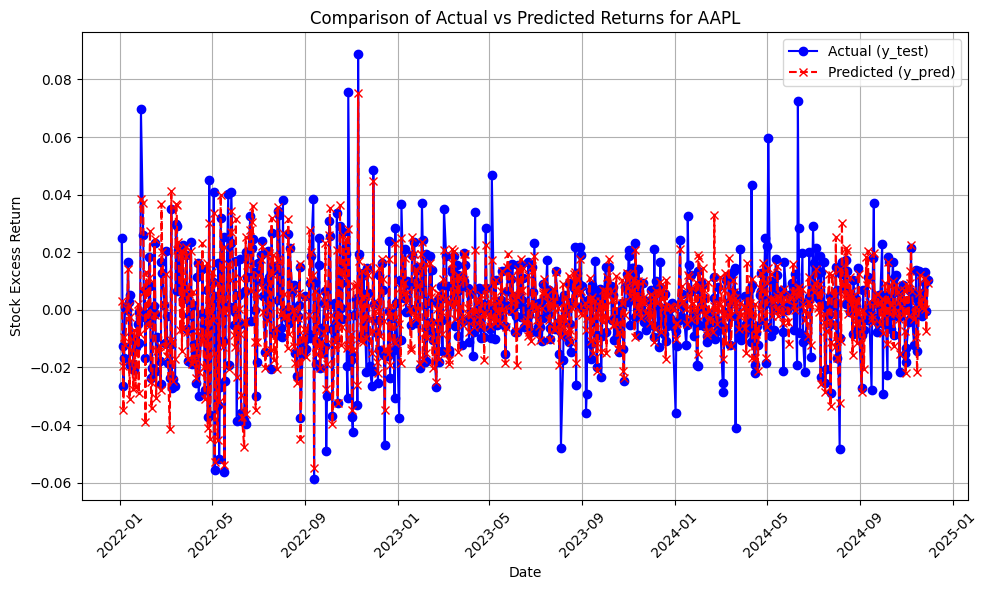

In [87]:
# CAPM test
y_test = Test_df[stock]
x_test = Test_df[['Mkt-RF', 'SMB', 'HML']]
y_pred = Test_df['RF'] + Test_df['Mkt-RF'] * model.params[0] + Test_df['SMB'] * model.params[1] + Test_df['HML'] * model.params[2]

# Calculate MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Plot y_test vs. y_pred
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], y_test, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], y_pred, label='Predicted (y_pred)', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Comparison of Actual vs Predicted Returns for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Excess Return')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

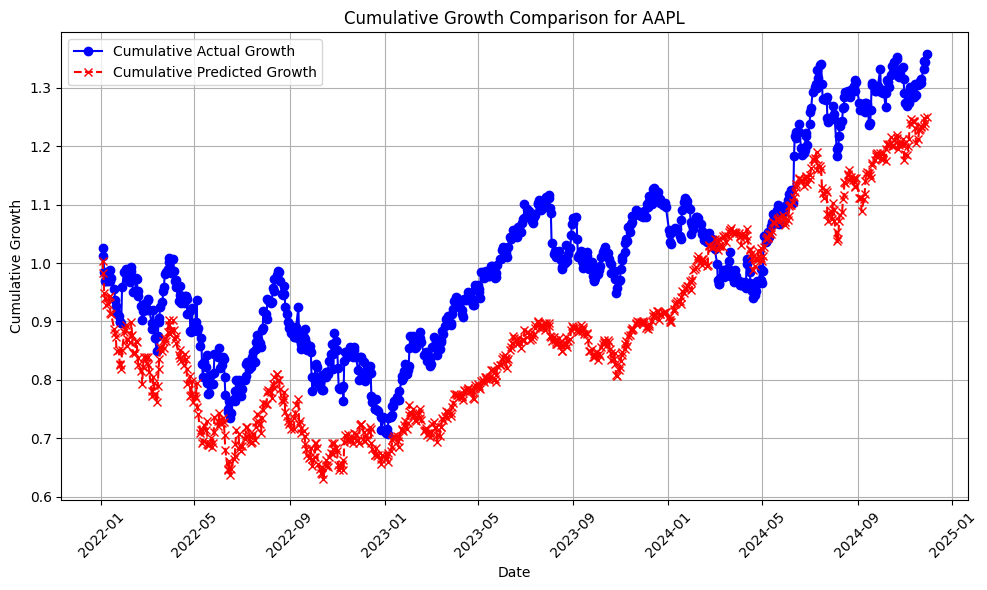

Final Cumulative Growth (Actual): 1.36
Final Cumulative Growth (Predicted): 1.25


In [88]:
# Calculate cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_predicted = (1 + y_pred).cumprod()

# Plot cumulative growth
plt.figure(figsize=(10, 6))
plt.plot(Test_df['Date'], cumulative_actual, label='Cumulative Actual Growth', marker='o', linestyle='-', color='blue')
plt.plot(Test_df['Date'], cumulative_predicted, label='Cumulative Predicted Growth', marker='x', linestyle='--', color='red')

# Add title and labels
plt.title(f'Cumulative Growth Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.grid(True)

# Show the graph
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# Print final cumulative growth values for comparison
print(f"Final Cumulative Growth (Actual): {cumulative_actual.iloc[-1]:.2f}")
print(f"Final Cumulative Growth (Predicted): {cumulative_predicted.iloc[-1]:.2f}")